**Introduction**:

To proceed with Data Analysis of Rocket League Professional Matches we need to draw data in from an external source. For the purposes of this project we will draw from Octane.GG . We will also define the team data that we will be pulling out. Most of the code is either provided with the API Documentation / ChatGPT

In [103]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

pd.set_option('display.max_columns', None)

In [104]:
def extract_stats(games):
    data = []
    for game in games:
        team_colors = ['blue', 'orange']
        for color in team_colors:
            try:
                team_name = game[color]['team']['team']['name']
                
                player_stats = game[color]['players']
                team_data = [{
                    'team': team_name,
                    'player': player['player'].get('tag'),
                    'shots': player['stats']['core'].get('shots'),
                    'goals': player['stats']['core'].get('goals'),
                    'saves': player['stats']['core'].get('saves'),
                    'assists': player['stats']['core'].get('assists'),
                    'score': player['stats']['core'].get('score'),
                    'shooting percentage': player['stats']['core'].get('shootingPercentage'),
                    'goal participation': player['advanced'].get('goalParticipation'),
                    'boost consumed / min.': player['stats']['boost'].get('bcpm'),
                    'boost collected': player['stats']['boost'].get('amountCollected'),
                    'boost stolen': player['stats']['boost'].get('amountStolen'),
                    'average boost amount': player['stats']['boost'].get('avgAmount'),
                    'time zero boost': player['stats']['boost'].get('timeZeroBoost'),
                    'time defensive half': player['stats']['positioning'].get('timeDefensiveHalf'),
                    'time offensive half': player['stats']['positioning'].get('timeOffensiveHalf'),
                    'time behind ball': player['stats']['positioning'].get('timeBehindBall'),
                    'demos inflicted': player['stats']['demo'].get('inflicted'),
                    'demos taken': player['stats']['demo'].get('taken'),
                    'time supersonic': player['stats']['movement'].get('timeSupersonicSpeed'),
                    'average speed': player['stats']['movement'].get('avgSpeed'),
                    'total distance covered': player['stats']['movement'].get('totalDistance'),
                    'avg. distance to ball': player['stats']['positioning'].get('avgDistanceToBall')              
                } for player in player_stats]
                
                data += team_data
            except KeyError:
                continue

    return data

In [105]:
def list_games(filters, page_range):
    results = []
    for page in range(page_range[0], page_range[1]+1):
        filters['page'] = str(page) 
        r = requests.get("https://zsr.octane.gg/games", params=filters)
        games = r.json()['games']
        game_stats = extract_stats(games)
        results += game_stats
    return results

We want to filter games within the API. We will go part by part. Firstly we want games only from 2021 - 2022 season and later. Rocket League is a quick pace, fastly evolving gameplay. Anything beforehand could start skewing the data, due to new trends emerging with every tournament.
    Further we want only games from Tier S and A, due to the fact that professional Tournaments are delegated by those letters, if we start looking at lower tiers ('B', 'C'). We might again start getting data from teams that aren't of high enough quality.
    Finally we limit where we get games from. Within the Professional Rocket League Scene there are many Continents / Regions that participate. Oceania, North America, Europe, South America, Middle East, Sub-Saharran Africa, Asia, and more. However sadly not each of these regions is as competitive, and we will only focus on North / South America, Europe, and Middle East (all of which have been huge contenders for Top spots on the world stage)

In [106]:
replays = list_games({'perPage': '500',
                      'after': '2021-14-10',
                      'tier': ['S', 'A'], 
                      'region':['NA','EU','SAM','ME']}, (1, 50))

Bellow we can see the output of what we are storing.

In [107]:
print(replays[:3])

[{'team': 'Lucky Bounce', 'player': 'DarkFire', 'shots': 4, 'goals': 1, 'saves': 2, 'assists': 0, 'score': 265, 'shooting percentage': 25, 'goal participation': 100, 'boost consumed / min.': 486.3608, 'boost collected': 2719, 'boost stolen': 250, 'average boost amount': 49.86, 'time zero boost': 40.53, 'time defensive half': 240.9, 'time offensive half': 112.04, 'time behind ball': 256.01, 'demos inflicted': 1, 'demos taken': 0, 'time supersonic': 47.7, 'average speed': 1478, 'total distance covered': 488809, 'avg. distance to ball': 2896}, {'team': 'Lucky Bounce', 'player': 'torment', 'shots': 1, 'goals': 0, 'saves': 1, 'assists': 1, 'score': 145, 'shooting percentage': 0, 'goal participation': 100, 'boost consumed / min.': 274.03632, 'boost collected': 1532, 'boost stolen': 334, 'average boost amount': 41.61, 'time zero boost': 86.4, 'time defensive half': 222.44, 'time offensive half': 124.2, 'time behind ball': 251.87, 'demos inflicted': 0, 'demos taken': 2, 'time supersonic': 26.6

We can for example show the last 30 Matches that we received from the Data Collection, and Teams / Players that were playing.

In [108]:
for replay in replays[-30:]:
    print(replay['team'] + " : " +replay['player'])

Mythical : Mag
Mythical : Sqy
Mythical : Talal.
Rapzers Esports : HMO
Rapzers Esports : scary
Rapzers Esports : Yazeed
Mythical : Talal.
Mythical : Mag
Mythical : Sqy
Rapzers Esports : scary
Rapzers Esports : Yazeed
Rapzers Esports : HMO
Mythical : Mag
Mythical : Sqy
Mythical : Talal.
Rapzers Esports : HMO
Rapzers Esports : scary
Rapzers Esports : Yazeed
Triple Esports : t9berh
Triple Esports : Abo fahad
Triple Esports : Willie
Missing : arb.
Missing : moayad
Missing : Ghassan
Triple Esports : Willie
Triple Esports : Abo fahad
Triple Esports : t9berh
Missing : Ghassan
Missing : arb.
Missing : moayad


**Analysis**:

We then utilize the Pandas to convert the stats into a Dataframe that can give us more information and we are able to utilize the Library methods to create models / plots of different values we might be searching for.

In [109]:
stats = pd.DataFrame(replays)

In [110]:
stats = stats.drop_duplicates()
stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135793 entries, 0 to 135804
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   team                    135793 non-null  object 
 1   player                  135793 non-null  object 
 2   shots                   135793 non-null  int64  
 3   goals                   135793 non-null  int64  
 4   saves                   135793 non-null  int64  
 5   assists                 135793 non-null  int64  
 6   score                   135793 non-null  int64  
 7   shooting percentage     135793 non-null  float64
 8   goal participation      135793 non-null  float64
 9   boost consumed / min.   135793 non-null  float64
 10  boost collected         135793 non-null  int64  
 11  boost stolen            135793 non-null  int64  
 12  average boost amount    135793 non-null  float64
 13  time zero boost         135793 non-null  float64
 14  time defensive half     1

In [111]:
stats.head(12)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball
0,Lucky Bounce,DarkFire,4,1,2,0,265,25.000000,100.000000,486.36080,2719,250,49.86,40.53,240.90,112.04,256.01,1,0,47.70,1478,488809,2896
1,Lucky Bounce,torment,1,0,1,1,145,0.000000,100.000000,274.03632,1532,334,41.61,86.40,222.44,124.20,251.87,0,2,26.66,1376,446614,2754
2,Lucky Bounce,Timbathy,0,0,1,0,65,0.000000,0.000000,305.87604,1710,514,42.90,39.47,223.63,129.22,257.31,1,0,36.09,1395,460248,3040
3,Kings of Urban,Sadjunior,3,2,0,1,320,66.666667,75.000000,441.10547,2466,575,49.87,33.11,226.97,122.78,257.56,0,1,64.29,1566,512896,3063
4,Kings of Urban,Jacob,5,2,1,0,300,40.000000,50.000000,399.24875,2232,655,50.03,33.26,205.21,147.63,221.22,0,0,41.09,1565,517557,2680
5,Kings of Urban,Fireburner,2,0,2,1,155,0.000000,25.000000,396.38675,2216,509,51.23,25.96,217.66,132.08,248.49,2,1,51.61,1474,483028,3014
6,Lucky Bounce,Timbathy,3,1,0,0,180,33.333333,100.000000,405.76800,2223,367,48.15,40.23,204.16,139.07,242.25,0,0,43.26,1558,505352,2985
7,Lucky Bounce,DarkFire,2,0,0,0,145,0.000000,0.000000,478.23310,2620,579,46.71,42.23,197.55,145.68,233.45,0,0,48.15,1552,503973,2764
8,Lucky Bounce,torment,0,0,0,0,105,0.000000,0.000000,327.64444,1795,473,41.28,51.00,199.87,142.21,247.04,0,1,18.93,1388,448680,2914
9,Kings of Urban,Fireburner,2,1,3,1,240,50.000000,66.666667,353.92902,1939,451,42.76,35.00,243.13,100.10,262.76,0,0,41.58,1376,446338,3294


While trying to bunch stats up into matches again, unfortunately errors popped up, looking at the number of players (which is just divided by 6, due to the fact that the game is 3v3), we can see that the remainder isn't 0. Thus we need to find the error inducing issue

In [112]:
print(len(stats) / 6)

22632.166666666668


The following code was used to find the offender within the data set. Since there was a +1 player somewhere, the team that was in trouble would not be divisible by 3. Then once we have the problem team, we look at their Matches and their IDs. So we search for more than 3 players in a row. Then we search for the one that is the single one out. There are more outliers, but since they are in sets of 3, that means the matches have this team back to back in the dataset. So we just try to look for a singular exception that doesn't follow the trend and we cut it out.

In [113]:
from collections import defaultdict

# Assuming 'team' and 'player' are the columns containing team names and player names respectively
team_player_dict = defaultdict(list)

i=0
# Iterate through each row in the DataFrame
for index, row in stats.iterrows():
    team = row['team']
    player = row['player']
    player_id = i
    if team not in team_player_dict:
        team_player_dict[team] = []
    team_player_dict[team].append((player, i))
    i += 1

# Check for outliers based on the criteria
outliers = [team for team, players in team_player_dict.items() if len(players) < 2 or len(players) % 3 != 0 or len(players) == 7]

# Print the outlier(s)
ammount = 0
if outliers:
    print("Outliers:")
    for team in outliers:
        print(f"Team: {team}, Players:")
        id_dif = 0
        number_in_row = 0
        last_id = 0
        for player, player_id in team_player_dict[team]:
            ammount += 1
            if(player_id-last_id == 1):
                if(number_in_row > 1):
                    print("Error Raised for the ID:", player_id, "Player:", player)
                    number_in_row += 1
                else:
                    number_in_row += 1
            else:
                number_in_row=0
            last_id = player_id


else:
    print("No outliers found.")
    
    


print(stats.iloc[89544])
stats = stats.drop(89544)

Outliers:
Team: XSET, Players:
Error Raised for the ID: 58266 Player: AlphaKep
Error Raised for the ID: 58267 Player: tcorrell.
Error Raised for the ID: 58268 Player: JPow
Error Raised for the ID: 77640 Player: JPow
Error Raised for the ID: 77641 Player: hockser
Error Raised for the ID: 77642 Player: AlphaKep
Error Raised for the ID: 81858 Player: AlphaKep
Error Raised for the ID: 81859 Player: hockser
Error Raised for the ID: 81860 Player: JPow
Error Raised for the ID: 89544 Player: Trey
team                           XSET
player                         Trey
shots                             0
goals                             0
saves                             2
assists                           0
score                           152
shooting percentage             0.0
goal participation              0.0
boost consumed / min.     343.89307
boost collected                 626
boost stolen                     48
average boost amount          41.73
time zero boost               24.66
ti

In [114]:
# Create a new column 'chunk' that assigns a unique integer to every chunk of 6 rows
stats['chunk'] = np.repeat(np.arange(len(stats)//6), 6)

# Group the stats dataframe by chunk
grouped = stats.groupby('chunk')

for chunk in grouped:
    
    # Select the second element of every chunk in grouped which contains the rows for every chunk
    chunk = chunk[1]
    
    # Calculate the number of goals for each team where team 1 is the first three rows and team 2 is the last three rows
    goals1 = chunk.iloc[:3]['goals'].sum()
    goals2 = chunk.iloc[3:]['goals'].sum()
    
    # Determine the winner of the current chunk based on which team scored more goals
    if goals1 > goals2:
        winner = 1
    else:
        winner = 0
        
    # Assign the value of 'winner' to the respective teams in the chunk, in a new column 'win'
    stats.loc[chunk.index[:3], 'win'] = winner
    stats.loc[chunk.index[3:], 'win'] = 1-winner
    
    # The last line assigns the opposite value of 'winner' from the first 3 rows to the last 3 rows in the chunk
    

In [115]:
stats.head(6)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,chunk,win
0,Lucky Bounce,DarkFire,4,1,2,0,265,25.000000,100.0,486.36080,2719,250,49.86,40.53,240.90,112.04,256.01,1,0,47.70,1478,488809,2896,0,0.0
1,Lucky Bounce,torment,1,0,1,1,145,0.000000,100.0,274.03632,1532,334,41.61,86.40,222.44,124.20,251.87,0,2,26.66,1376,446614,2754,0,0.0
2,Lucky Bounce,Timbathy,0,0,1,0,65,0.000000,0.0,305.87604,1710,514,42.90,39.47,223.63,129.22,257.31,1,0,36.09,1395,460248,3040,0,0.0
3,Kings of Urban,Sadjunior,3,2,0,1,320,66.666667,75.0,441.10547,2466,575,49.87,33.11,226.97,122.78,257.56,0,1,64.29,1566,512896,3063,0,1.0
4,Kings of Urban,Jacob,5,2,1,0,300,40.000000,50.0,399.24875,2232,655,50.03,33.26,205.21,147.63,221.22,0,0,41.09,1565,517557,2680,0,1.0
5,Kings of Urban,Fireburner,2,0,2,1,155,0.000000,25.0,396.38675,2216,509,51.23,25.96,217.66,132.08,248.49,2,1,51.61,1474,483028,3014,0,1.0


In [116]:
stats = stats.drop('chunk', axis=1)

In [117]:
stats.to_csv('C:\\Users\\Martin\\documents\\rl_stats.csv')

In [118]:
stats.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,win
count,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,1.357920e+05,135792.000000,135792.000000
mean,2.721191,0.654096,1.609668,0.518955,358.539303,22.736176,50.840868,418.060163,2457.990920,537.079747,48.844071,43.690442,236.259839,127.632125,263.497651,0.964181,0.964195,55.357746,1544.979756,5.336471e+05,2907.239926,0.500000
std,1.702957,0.823538,1.308301,0.727009,154.180666,30.337559,40.583604,49.587141,526.223311,230.891237,4.760631,17.399234,48.714896,32.808840,51.341983,1.085404,1.024520,17.808192,76.628823,1.000858e+05,226.532523,0.500002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.238597,12.000000,0.000000,17.890000,0.940000,49.750000,0.000000,44.490000,0.000000,0.000000,0.000000,546.000000,2.183800e+04,1960.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,245.000000,0.000000,0.000000,384.569433,2149.000000,374.000000,45.700000,31.580000,208.460000,106.957500,235.780000,0.000000,0.000000,43.230000,1494.000000,4.848840e+05,2755.000000,0.000000
50%,3.000000,0.000000,1.000000,0.000000,337.000000,0.000000,50.000000,417.428285,2370.000000,510.000000,48.910000,41.740000,228.360000,123.890000,253.040000,1.000000,1.000000,53.240000,1546.000000,5.093705e+05,2906.000000,0.500000
75%,4.000000,1.000000,2.000000,1.000000,448.000000,40.000000,100.000000,450.891230,2633.000000,668.000000,52.060000,53.350000,251.100000,142.632500,274.060000,2.000000,2.000000,64.810000,1597.000000,5.411075e+05,3057.000000,1.000000
max,17.000000,8.000000,16.000000,7.000000,1742.000000,300.000000,150.000000,684.872250,9891.000000,2939.000000,72.660000,239.580000,1016.840000,616.770000,1039.820000,18.000000,9.000000,254.230000,2021.000000,2.184390e+06,4707.000000,1.000000


In [119]:
df_summary_latex = stats.describe().to_latex()

# Write LaTeX table to a file
with open('summary.tex', 'w') as f:
    f.write(df_summary_latex)

In [120]:
print(stats[stats['score'] == 0])

                 team    player  shots  goals  saves  assists  score  \
11657   Evil Geniuses   Klassux      0      0      0        0      0   
115002  Natus Vincere  virtuoso      0      0      0        0      0   
116997     Fox Gaming    AbuLba      0      0      0        0      0   

        shooting percentage  goal participation  boost consumed / min.  \
11657                   0.0                 0.0             431.175050   
115002                  0.0                 0.0               6.556382   
116997                  0.0                 0.0               2.238597   

        boost collected  boost stolen  average boost amount  time zero boost  \
11657              2283           905                 52.62            28.31   
115002               36             0                 20.68            26.87   
116997               12             0                 17.89            92.01   

        time defensive half  time offensive half  time behind ball  \
11657                17

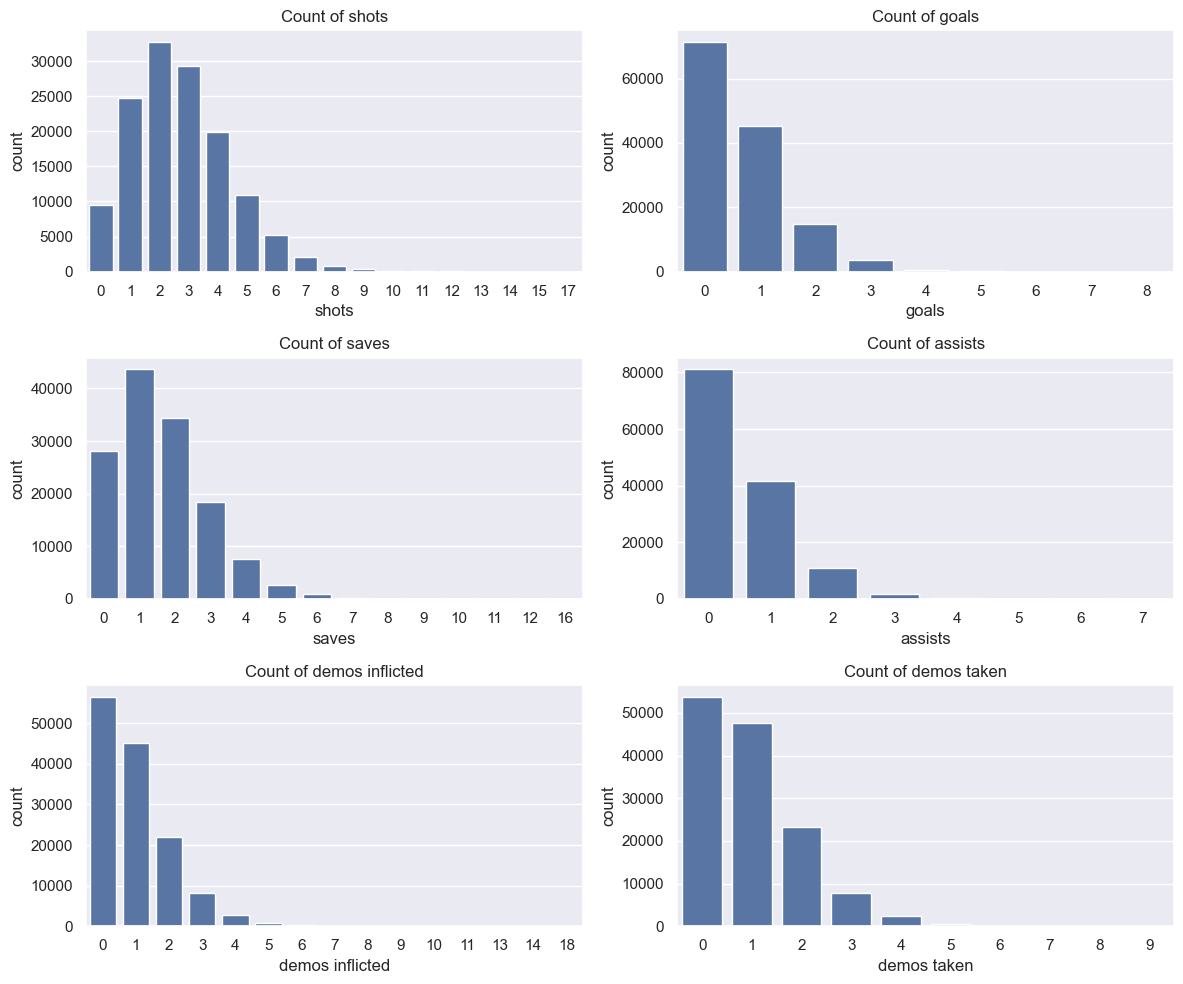

In [121]:
count_stats = ['shots', 'goals', 'saves', 'assists', 'demos inflicted', 'demos taken']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2  # Floor division results in values 0, 0, 1, 1, 2, 2
    col = i % 2   # Modulus division results in values 0, 1, 0, 1, 0, 1
                  # Together, they assign the location of the subplot on the 3x2 figure

    sns.countplot(x=stat, data=stats, ax=axs[row, col])
    axs[row, col].set_title('Count of ' + stat)

plt.tight_layout()
plt.savefig('stats_plot.png')  # Save the plot as 'stats_plot.png'
plt.show()

In [122]:
stats.head(6)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,win
0,Lucky Bounce,DarkFire,4,1,2,0,265,25.000000,100.0,486.36080,2719,250,49.86,40.53,240.90,112.04,256.01,1,0,47.70,1478,488809,2896,0.0
1,Lucky Bounce,torment,1,0,1,1,145,0.000000,100.0,274.03632,1532,334,41.61,86.40,222.44,124.20,251.87,0,2,26.66,1376,446614,2754,0.0
2,Lucky Bounce,Timbathy,0,0,1,0,65,0.000000,0.0,305.87604,1710,514,42.90,39.47,223.63,129.22,257.31,1,0,36.09,1395,460248,3040,0.0
3,Kings of Urban,Sadjunior,3,2,0,1,320,66.666667,75.0,441.10547,2466,575,49.87,33.11,226.97,122.78,257.56,0,1,64.29,1566,512896,3063,1.0
4,Kings of Urban,Jacob,5,2,1,0,300,40.000000,50.0,399.24875,2232,655,50.03,33.26,205.21,147.63,221.22,0,0,41.09,1565,517557,2680,1.0
5,Kings of Urban,Fireburner,2,0,2,1,155,0.000000,25.0,396.38675,2216,509,51.23,25.96,217.66,132.08,248.49,2,1,51.61,1474,483028,3014,1.0


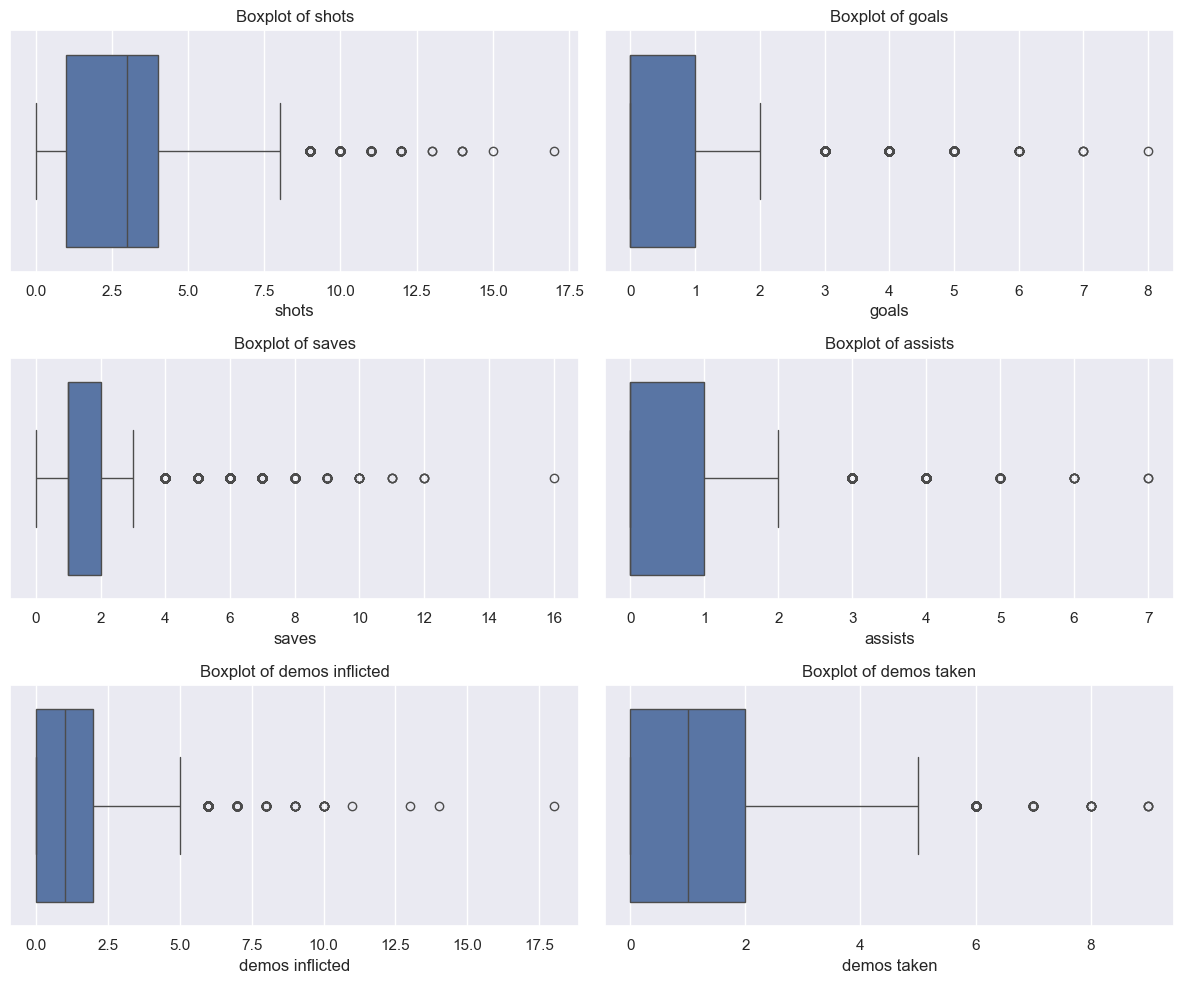

In [123]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2
    col = i % 2
    sns.boxplot(x=stat, data=stats, ax=axs[row, col])
    axs[row, col].set_title('Boxplot of ' + stat)

plt.tight_layout()
plt.show()

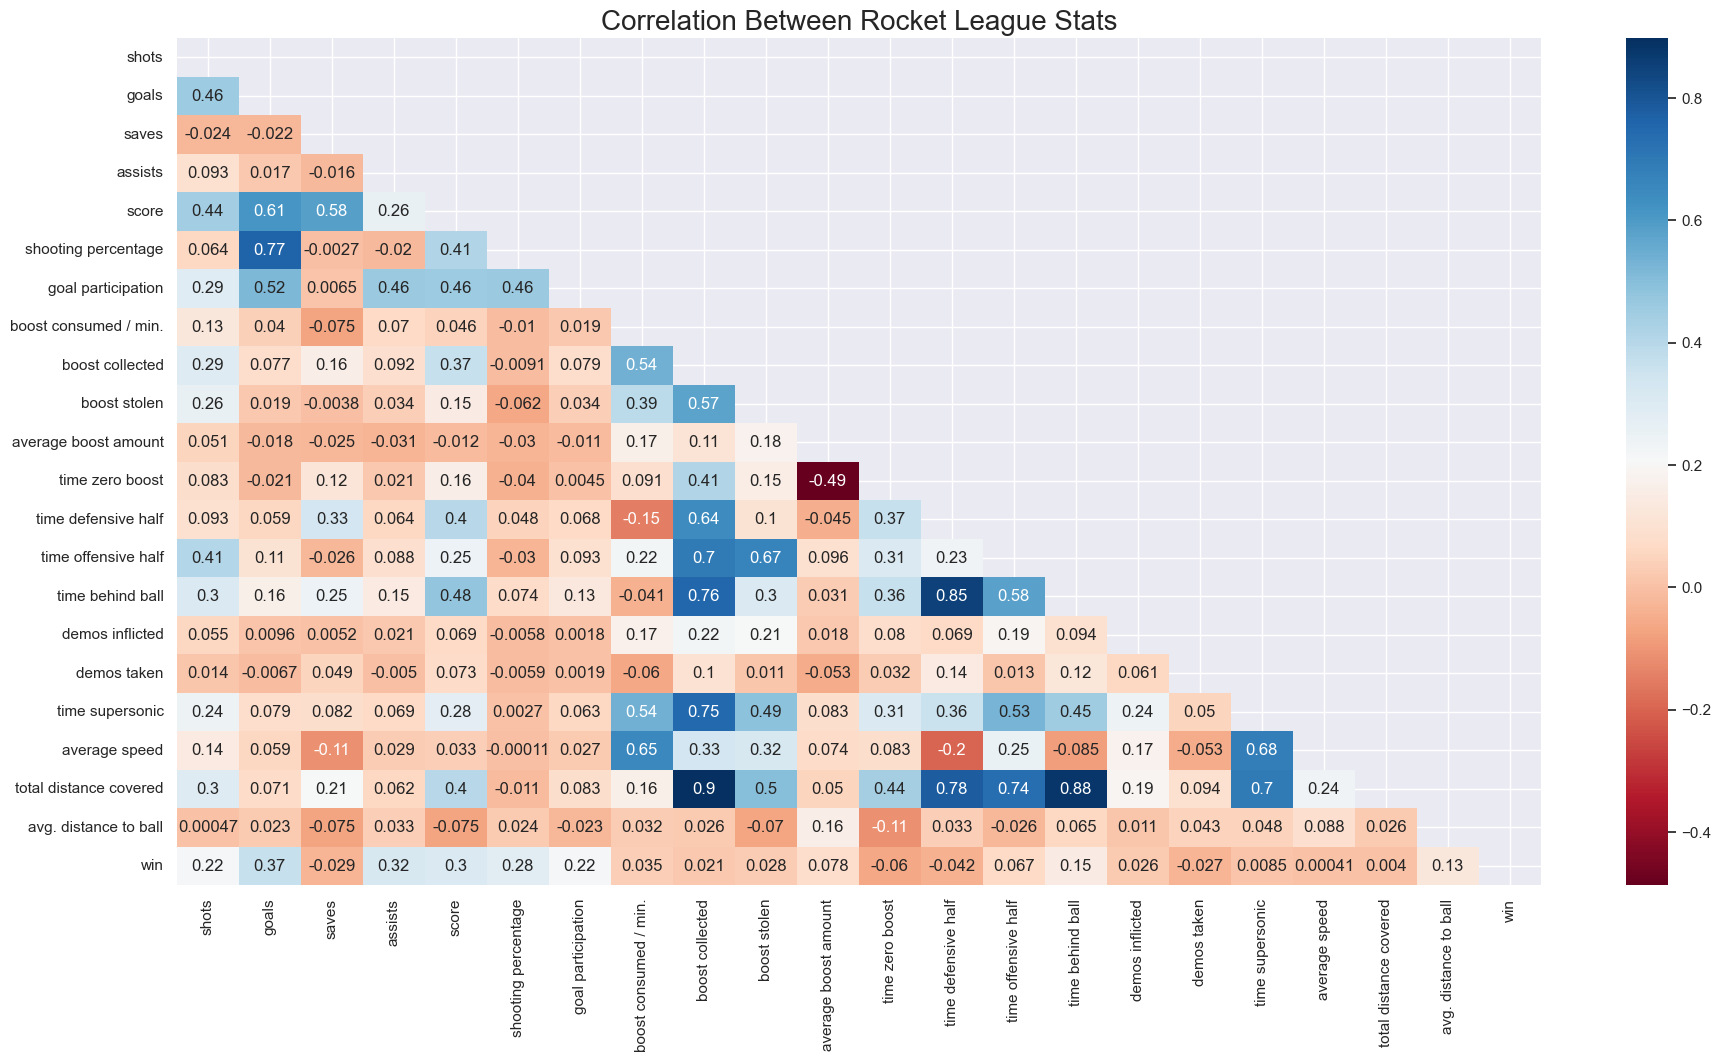

In [124]:
sns.set(rc={'figure.figsize':(22,11)})

# Select only the numeric columns for correlation analysis
numeric_columns = stats.select_dtypes(include=np.number)

# Check each numeric column for non-numeric values
for column in numeric_columns:
    try:
        numeric_columns[column] = pd.to_numeric(numeric_columns[column])
    except ValueError:
        print(f"Non-numeric values found in column '{column}'")

# Create a mask that hides the upper half of the matrix to avoid redundancy and clutter
corrmask = np.triu(np.ones_like(numeric_columns.corr())) 

# Plot correlation heatmap
sns.heatmap(numeric_columns.corr(), annot=True, cmap='RdBu', mask=corrmask)
plt.title('Correlation Between Rocket League Stats', fontsize=20)
plt.savefig('correlation_heatmap.png')

In [125]:
winners = stats[stats['win'] == 1]
losers = stats[stats['win'] == 0]

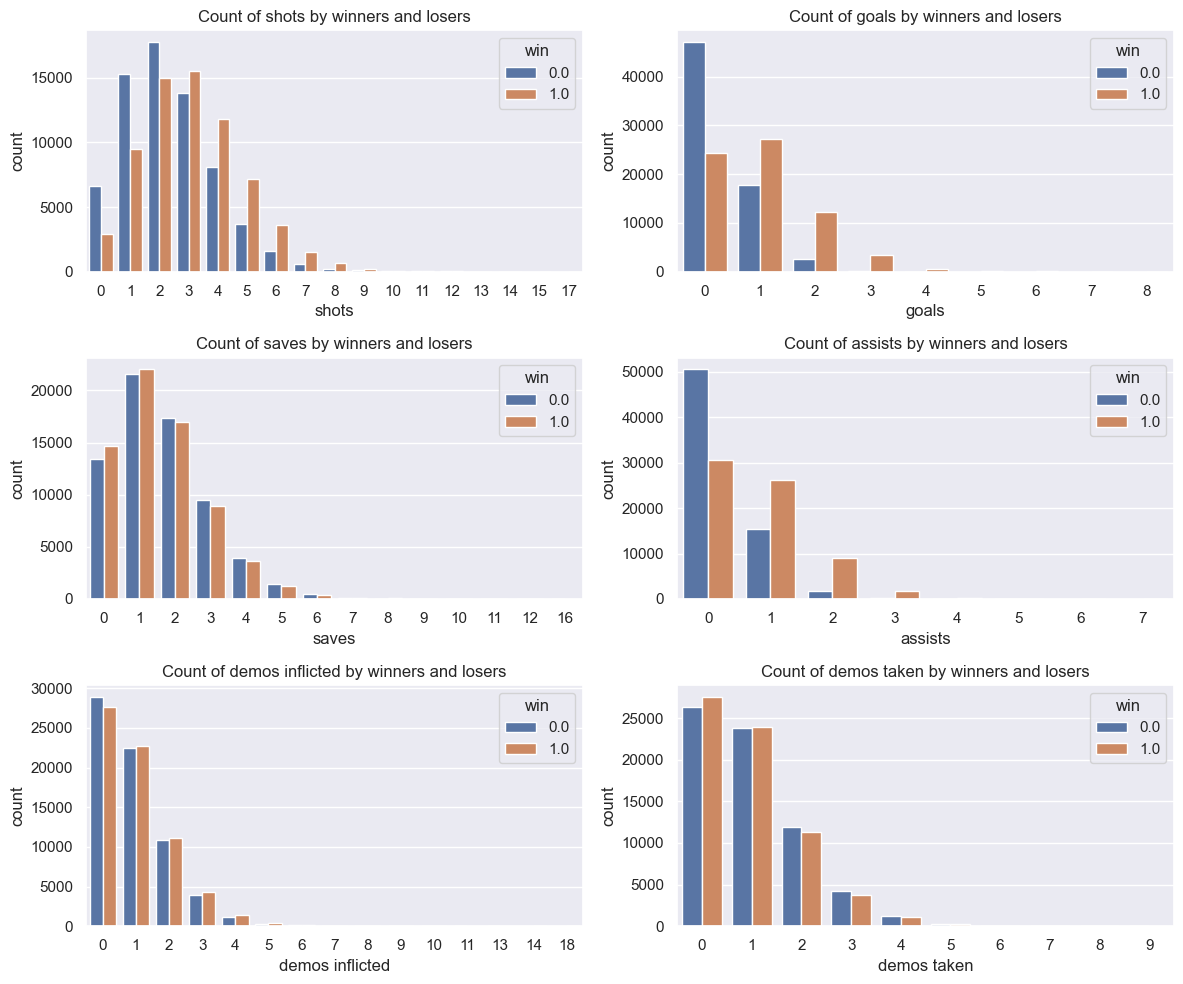

In [126]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2
    col = i % 2
    sns.countplot(x=stat, data=stats, ax=axs[row, col], hue='win')
    axs[row, col].set_title('Count of ' + stat + ' by winners and losers')

plt.tight_layout()
plt.savefig('win_loss_plot.png')
plt.show()

In [127]:
winners.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,win
count,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,6.789600e+04,67896.000000,67896.0
mean,3.087546,0.956728,1.571934,0.751723,405.529192,31.299448,59.594254,419.811010,2468.943193,543.536541,49.214366,42.647431,234.234692,129.833701,271.206428,0.992135,0.936300,55.509919,1545.011046,5.340476e+05,2936.427080,1.0
std,1.746382,0.919908,1.294130,0.823291,157.894492,31.897152,32.656411,49.291977,528.726208,233.933744,4.666745,17.052867,47.420547,33.654442,49.321015,1.108542,1.006317,17.813636,76.097303,1.005506e+05,228.822019,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,121.310750,552.000000,12.000000,27.580000,1.000000,58.810000,20.100000,63.780000,0.000000,0.000000,6.430000,744.000000,1.240740e+05,1960.000000,1.0
25%,2.000000,0.000000,1.000000,0.000000,291.000000,0.000000,33.333333,386.454858,2158.000000,379.000000,46.130000,30.790000,207.550000,108.490000,245.330000,0.000000,0.000000,43.360000,1495.000000,4.847138e+05,2783.000000,1.0
50%,3.000000,1.000000,1.000000,1.000000,386.000000,25.000000,60.000000,419.349650,2378.000000,515.000000,49.290000,40.720000,226.730000,125.770000,260.950000,1.000000,1.000000,53.380000,1546.000000,5.094635e+05,2935.000000,1.0
75%,4.000000,1.000000,2.000000,1.000000,500.000000,50.000000,100.000000,452.372037,2643.000000,675.000000,52.340000,52.000000,248.360000,144.990000,280.130000,2.000000,1.000000,64.860000,1597.000000,5.413865e+05,3087.000000,1.0
max,17.000000,8.000000,12.000000,7.000000,1742.000000,300.000000,150.000000,684.872250,9606.000000,2636.000000,72.660000,209.230000,1016.840000,518.250000,1039.820000,18.000000,8.000000,229.150000,2021.000000,2.060668e+06,4367.000000,1.0


In [128]:
losers.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,win
count,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,67896.000000,6.789600e+04,67896.000000,67896.0
mean,2.354837,0.351464,1.647402,0.286188,311.549414,14.172904,42.087482,416.309317,2447.038647,530.622953,48.473776,44.733452,238.284986,125.430550,255.788875,0.936226,0.992091,55.205572,1544.948465,5.332466e+05,2878.052772,0.0
std,1.575398,0.571869,1.321252,0.520499,134.895778,26.012667,45.545529,49.819428,523.483251,227.626742,4.824396,17.677531,49.893952,31.788996,52.159587,1.061035,1.041666,17.801577,77.157230,9.961809e+04,220.389207,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.238597,12.000000,0.000000,17.890000,0.940000,49.750000,0.000000,44.490000,0.000000,0.000000,0.000000,546.000000,2.183800e+04,1977.000000,0.0
25%,1.000000,0.000000,1.000000,0.000000,214.000000,0.000000,0.000000,382.748200,2141.000000,370.000000,45.290000,32.410000,209.500000,105.470000,228.080000,0.000000,0.000000,43.120000,1494.000000,4.850718e+05,2730.000000,0.0
50%,2.000000,0.000000,1.000000,0.000000,290.000000,0.000000,0.000000,415.376035,2361.000000,504.000000,48.530000,42.830000,230.060000,122.120000,243.975000,1.000000,1.000000,53.090000,1546.000000,5.092815e+05,2877.000000,0.0
75%,3.000000,1.000000,2.000000,1.000000,387.000000,25.000000,100.000000,449.296095,2621.000000,660.000000,51.740000,54.642500,253.790000,140.280000,264.290000,1.000000,2.000000,64.750000,1598.000000,5.407775e+05,3025.000000,0.0
max,14.000000,4.000000,16.000000,5.000000,1549.000000,200.000000,100.000000,645.539250,9891.000000,2939.000000,68.280000,239.580000,876.420000,616.770000,1027.360000,13.000000,9.000000,254.230000,1874.000000,2.184390e+06,4707.000000,0.0


In [129]:
# Ratio of summary statistics
winners.describe() / losers.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed / min.,boost collected,boost stolen,average boost amount,time zero boost,time defensive half,time offensive half,time behind ball,demos inflicted,demos taken,time supersonic,average speed,total distance covered,avg. distance to ball,win
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
mean,1.311151,2.722122,0.954189,2.626679,1.301653,2.208400,1.415962,1.008411,1.008951,1.024337,1.015278,0.953368,0.983002,1.035104,1.060275,1.059717,0.943764,1.005513,1.000041,1.001502,1.020283,inf
std,1.108534,1.608599,0.979472,1.581733,1.170492,1.226216,0.717006,0.989413,1.010016,1.027708,0.967322,0.964663,0.950427,1.058682,0.945579,1.044774,0.966065,1.000677,0.986263,1.009361,1.038263,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.190522,46.000000,inf,1.541643,1.063830,1.182111,inf,1.433581,NaN,NaN,inf,1.362637,5.681564,0.991401,inf
25%,2.000000,NaN,1.000000,NaN,1.359813,NaN,inf,1.009684,1.007940,1.024324,1.018547,0.950015,0.990692,1.028634,1.075631,NaN,NaN,1.005566,1.000669,0.999262,1.019414,inf
50%,1.500000,inf,1.000000,inf,1.331034,inf,inf,1.009566,1.007200,1.021825,1.015660,0.950735,0.985526,1.029889,1.069577,1.000000,1.000000,1.005462,1.000000,1.000357,1.020160,inf
75%,1.333333,1.000000,1.000000,1.000000,1.291990,2.000000,1.000000,1.006846,1.008394,1.022727,1.011596,0.951640,0.978604,1.033576,1.059934,2.000000,0.500000,1.001699,0.999374,1.001126,1.020496,inf
max,1.214286,2.000000,0.750000,1.400000,1.124597,1.500000,1.500000,1.060930,0.971186,0.896904,1.064148,0.873320,1.160220,0.840265,1.012128,1.384615,0.888889,0.901349,1.078442,0.943361,0.927767,inf


In [130]:
visual_stats = ['shots', 'goals', 'saves', 'assists', 'score', 'shooting percentage',
                'goal participation', 'boost consumed / min.', 'boost collected', 'boost stolen', 
                'average boost amount', 'time zero boost', 'time defensive half', 
                'time offensive half', 'time behind ball', 'demos inflicted',
                'demos taken', 'time supersonic', 'average speed', 
                'total distance covered', 'avg. distance to ball'
                ]
means = pd.DataFrame()



means['winners'] = winners[visual_stats].mean()
means['losers'] = losers[visual_stats].mean()
means

,winners,losers
shots,3.087546,2.354837
goals,0.956728,0.351464
saves,1.571934,1.647402
assists,0.751723,0.286188
score,405.529192,311.549414
shooting percentage,31.299448,14.172904
goal participation,59.594254,42.087482
boost consumed / min.,419.811010,416.309317
boost collected,2468.943193,2447.038647
boost stolen,543.536541,530.622953


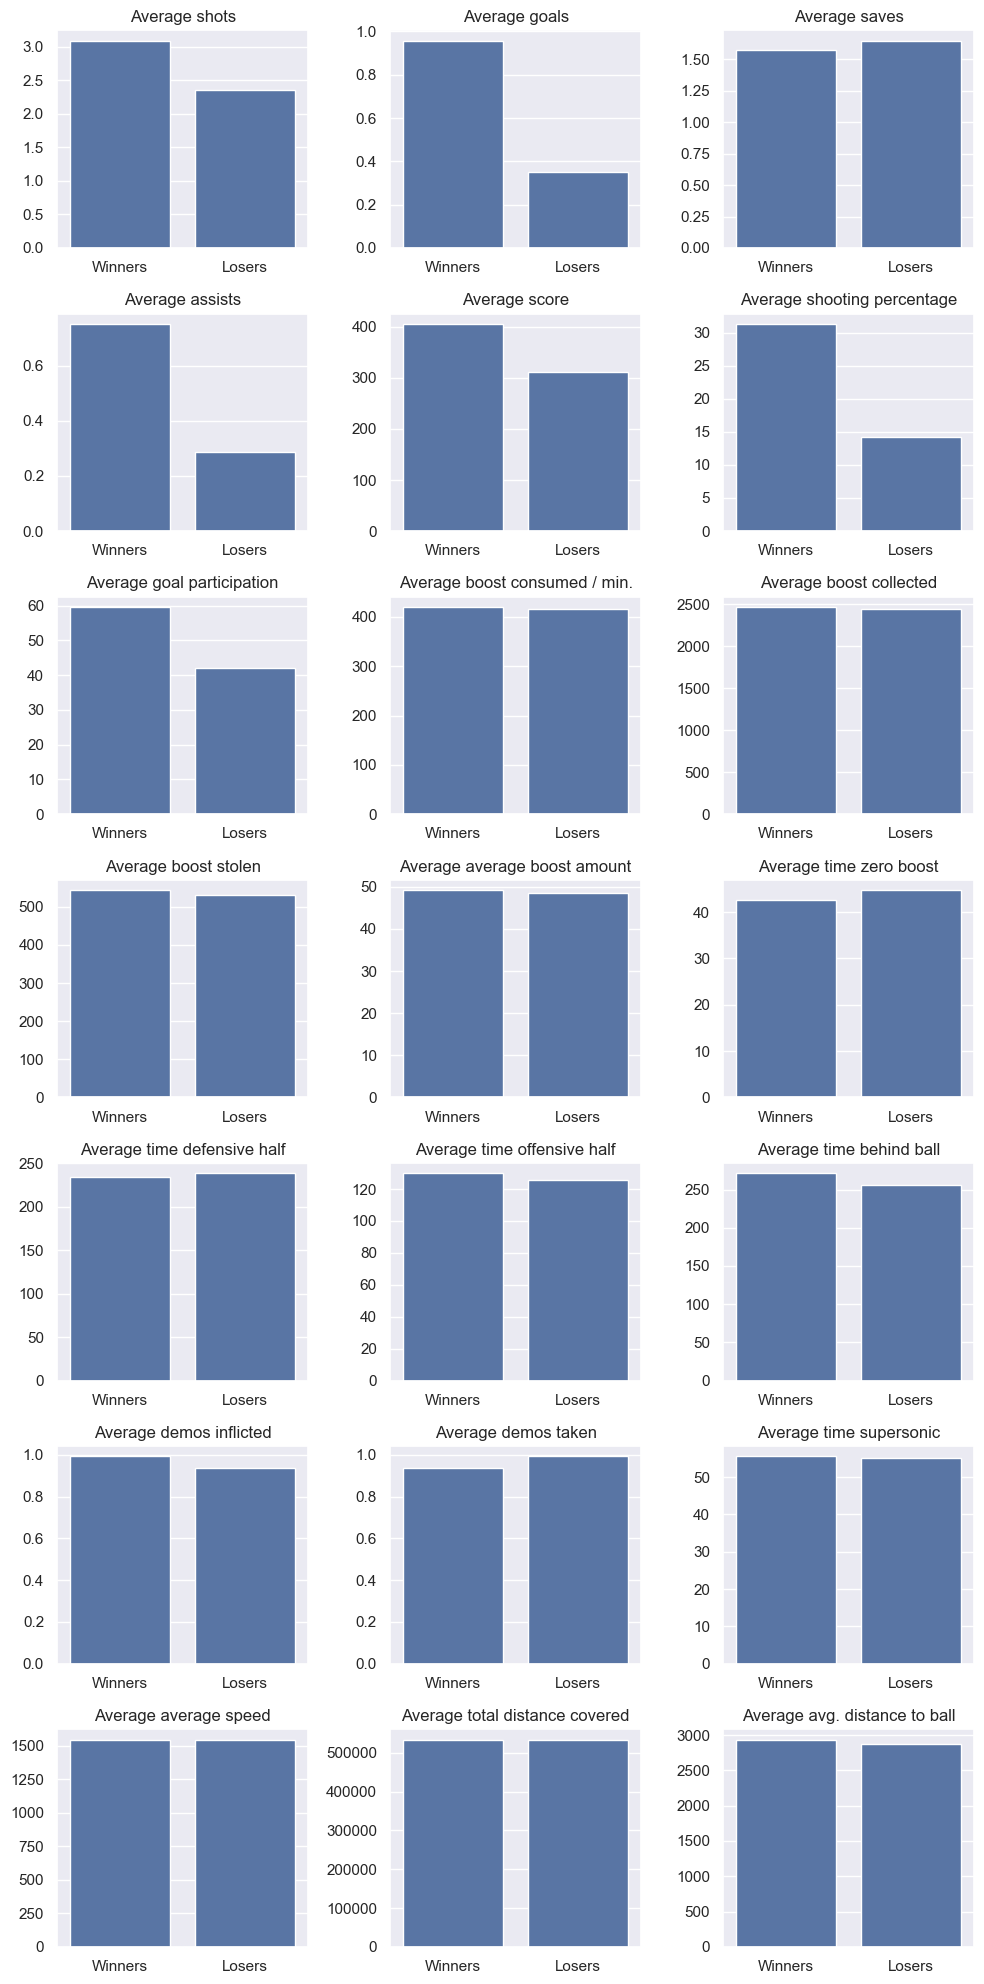

In [131]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 20))

for i, stat in enumerate(visual_stats):
        ax = axs[i // 3, i % 3]
        sns.barplot(x=['Winners', 'Losers'],
                    y=[means['winners'].iloc[i], means['losers'].iloc[i]],
                    ax=ax)
        ax.set_title('Average ' + stat)
    
plt.tight_layout()
plt.show()

In [132]:
stats_list = ['goals', 'assists', 'saves', 'shots', 'score']

for stat in stats_list:
    IQR = stats[stat].quantile(0.75) - stats[stat].quantile(0.25)
    Lower_fence = stats[stat].quantile(0.25) - (IQR * 3)  # (IQR * 1.5) if we were looking for greater than inner fence values
    Upper_fence = stats[stat].quantile(0.75) + (IQR * 3)
    print('extreme outliers for {s} are values < {lowerboundary} or > {upperboundary}'
          .format(s=stat, lowerboundary=Lower_fence, upperboundary=Upper_fence))
    print('max number of {s} is {m}'.format(s=stat, m=stats[stat].max()))
    print('mean number of {s} is {m}'.format(s=stat, m=stats[stat].mean()))
    print('')

extreme outliers for goals are values < -3.0 or > 4.0
max number of goals is 8
mean number of goals is 0.6540959703075292

extreme outliers for assists are values < -3.0 or > 4.0
max number of assists is 7
mean number of assists is 0.5189554612937434

extreme outliers for saves are values < -2.0 or > 5.0
max number of saves is 16
mean number of saves is 1.6096677271120536

extreme outliers for shots are values < -8.0 or > 13.0
max number of shots is 17
mean number of shots is 2.7211912336514668

extreme outliers for score are values < -364.0 or > 1057.0
max number of score is 1742
mean number of score is 358.539302757158



In [133]:
data = stats.filter(['team', 'player', 'goals', 'assists', 'saves', 'shots', 'score', 'win'])

In [134]:
data['goals'] = data['goals'].clip(upper=4)

data['assists'] = data['assists'].clip(upper=4)

data['saves'] = data['saves'].clip(upper=5)

data['shots'] = data['shots'].clip(upper=13)

data['score'] = data['score'].clip(upper=1057.0)

data.describe()

,goals,assists,saves,shots,score,win
count,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000,135792.000000
mean,0.652969,0.518521,1.596780,2.721125,358.454975,0.500000
std,0.817944,0.724504,1.264179,1.702507,153.725211,0.500002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,245.000000,0.000000
50%,0.000000,0.000000,1.000000,3.000000,337.000000,0.500000
75%,1.000000,1.000000,2.000000,4.000000,448.000000,1.000000
max,4.000000,4.000000,5.000000,13.000000,1057.000000,1.000000


In [135]:
model_stats = data[['goals', 'assists', 'saves', 'shots', 'score']]

model_stats = sm.add_constant(model_stats)

vif = pd.DataFrame()
vif['feature'] = model_stats.columns
vif['vif'] = [variance_inflation_factor(model_stats.values, i)
                           for i in range(len(model_stats.columns))]
print(vif)

   feature       vif
0    const  8.076799
1    goals  2.814721
2  assists  1.330940
3    saves  2.944620
4    shots  1.486542
5    score  5.476663


In [136]:
model_stats = data[['goals', 'assists', 'saves', 'shots']]

model_stats = sm.add_constant(model_stats)

vif = pd.DataFrame()
vif['feature'] = model_stats.columns
vif['vif'] = [variance_inflation_factor(model_stats.values, i)
                           for i in range(len(model_stats.columns))]
print(vif)

   feature       vif
0    const  5.625143
1    goals  1.266148
2  assists  1.009813
3    saves  1.001119
4    shots  1.277206


In [137]:
X = data[['goals', 'assists', 'saves', 'shots']]
y = data['win']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123)

In [138]:
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())
summary_table = result.summary().as_text()

with open('logit_regression_summary.tex', 'w') as f:
    f.write(summary_table)

Optimization terminated successfully.
         Current function value: 0.553271
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:               101844
Model:                          Logit   Df Residuals:                   101839
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:                  0.2018
Time:                        15:55:01   Log-Likelihood:                -56347.
converged:                       True   LL-Null:                       -70593.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3539      0.018    -76.330      0.000      -1.389      -1.319
goals          1.2015      0.

Test accuracy =  0.6995404736656062


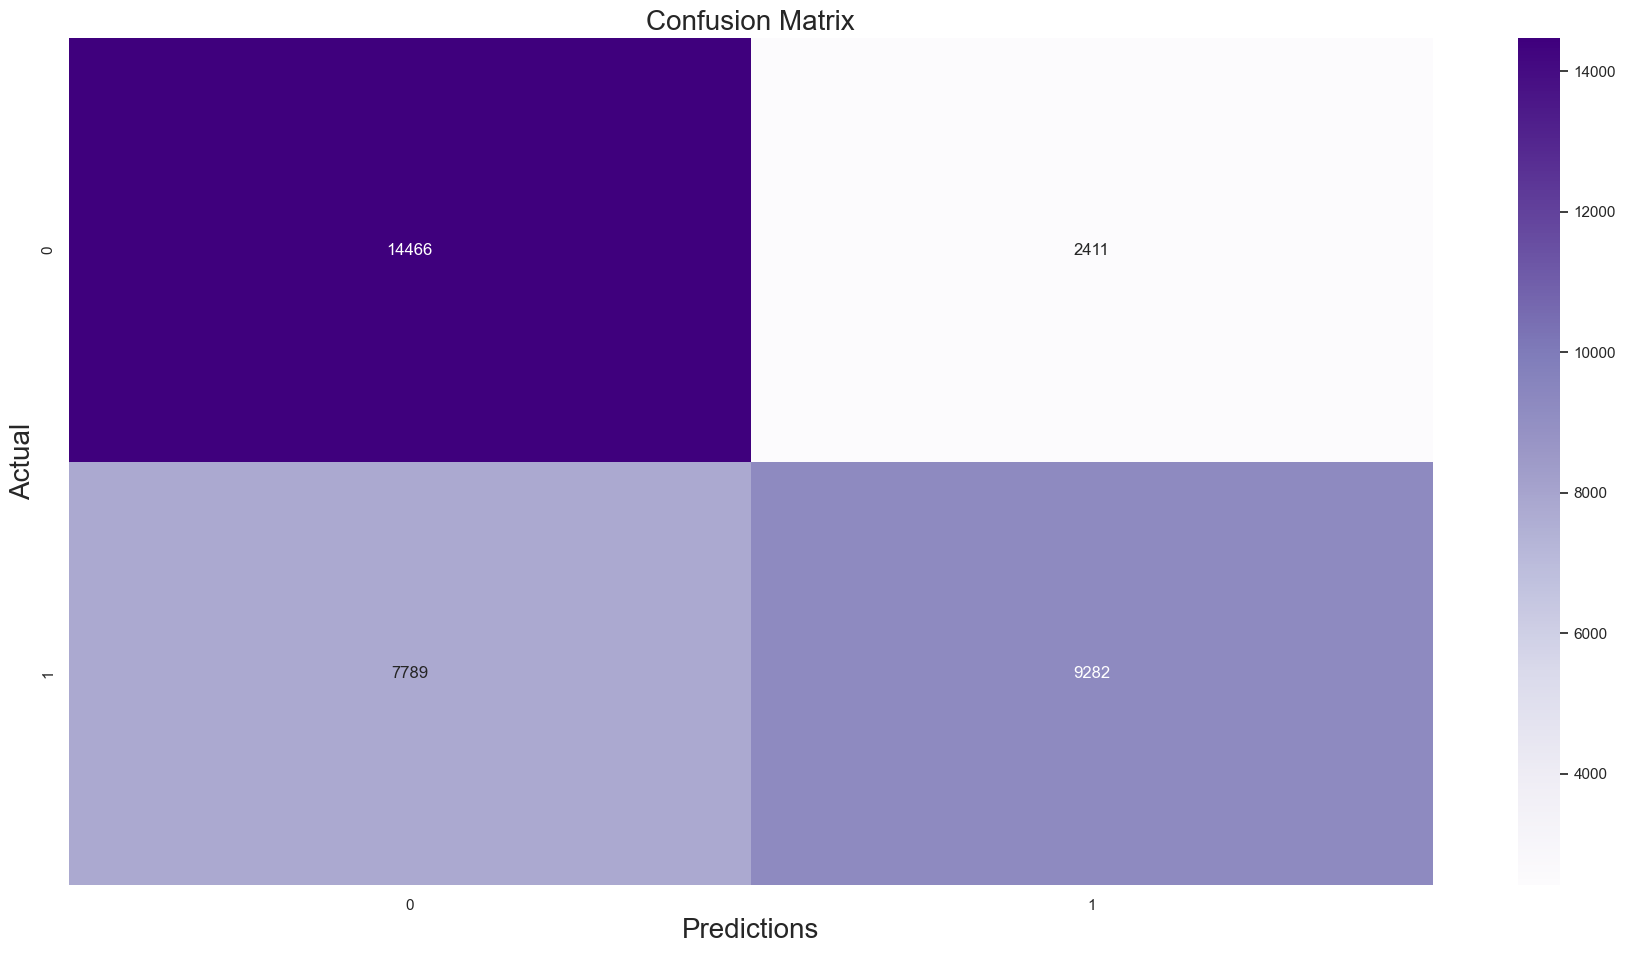

In [139]:
pred = result.predict(X_test)
prediction = list(map(round, pred))

print('Test accuracy = ', accuracy_score(y_test, prediction))

cm = confusion_matrix(y_test, prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', ax=ax)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig('Confusion Matrix.png')
plt.show()


In [140]:
predictions = []
for index, row in data.iterrows():
    scoreline = [row['goals'], row['assists'], row['saves'], row['shots'], row['score']]
    predict_data = {'const': 1, 'goals': scoreline[0], 'assists': scoreline[1],
                    'saves': scoreline[2], 'shots': scoreline[3]}
    predict_data = pd.DataFrame(data=predict_data, index = [0])
    prediction = result.predict(predict_data)
    predictions.append(prediction[0])

In [141]:
data['probability of winning'] = predictions
data['probability of winning'] = round(data['probability of winning'], 2)

In [142]:
data.head(6)

,team,player,goals,assists,saves,shots,score,win,probability of winning
0,Lucky Bounce,DarkFire,1,0,2,4,265,0.0,0.48
1,Lucky Bounce,torment,0,1,1,1,145,0.0,0.46
2,Lucky Bounce,Timbathy,0,0,1,0,65,0.0,0.20
3,Kings of Urban,Sadjunior,2,1,0,3,320,1.0,0.91
4,Kings of Urban,Jacob,2,0,1,5,300,1.0,0.77
5,Kings of Urban,Fireburner,0,1,2,2,155,1.0,0.46


In [143]:
print(data[(data['goals'] > 3)
         & (data['win'] == 0)].head())

                team     player  goals  assists  saves  shots  score  win  \
48        Allegiance   Sea-Bass      4        0      3      5    530  0.0   
1209      Allegiance   Allushin      4        1      2      5    510  0.0   
9585       Team Envy  EyeIgnite      4        0      0      4    440  0.0   
11289  exceL Esports  Nielskoek      4        0      0      4    440  0.0   
15825  Evil Geniuses    Klassux      4        0      0      6    605  0.0   

       probability of winning  
48                       0.97  
1209                     0.99  
9585                     0.97  
11289                    0.97  
15825                    0.97  


In [144]:
print('maximum probability of winning : {max}'.format(max = data['probability of winning'].max()))
print('number of games where the probability of winning is more than or equal to 0.7 and players lose: {number}'
      .format(number = len(data[(data['probability of winning'] >= 0.7)
                        & (data['win'] == 0)])))

maximum probability of winning : 1.0
number of games where the probability of winning is more than or equal to 0.7 and players lose: 8367


In [145]:
print(data[(data['goals'] == 0) 
         & (data['saves'] == 0) 
         & (data['assists'] == 0)
         & (data['shots'] == 0)
         & (data['win'] == 1)].head())

                team      player  goals  assists  saves  shots  score  win  \
248   The Juicy Kids        Frag      0        0      0      0     60  1.0   
533    SetToDestroyX  Lemonpuppy      0        0      0      0     80  1.0   
989           Exodus      Turtle      0        0      0      0     40  1.0   
1334        Prophecy     Sebadam      0        0      0      0    110  1.0   
1493  Denial Esports  CorruptedG      0        0      0      0     45  1.0   

      probability of winning  
248                     0.21  
533                     0.21  
989                     0.21  
1334                    0.21  
1493                    0.21  


In [146]:
print('minimum probability of winning : {min}'.format(min = data['probability of winning'].min()))
print('number of games where the probability of winning is less than or equal to 0.3 and players win: {number}'
      .format(number = len(data[(data['probability of winning'] <= 0.3)
                        & (data['win'] == 1)])))

minimum probability of winning : 0.17
number of games where the probability of winning is less than or equal to 0.3 and players win: 8634
